In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import precision_recall_fscore_support
from itertools import cycle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
#independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_2_indep_asso_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [22]:
# removed independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_2_2_removed_indep_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [4]:
# removed descriptor training
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_2_removed_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [21]:
#2017.3.15.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/7_2_1_tn_whole_descriptor_removed.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [5]:
#2017.3.14.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/6_2_1_tn_whole_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [4]:
#기존 데이터
#association_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/9_gold_learning_association.tsv")
#descriptor_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv", header=None) # 이거 현재 바뀜.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [9]:
# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_1%.tsv")
x_whole_data_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_1 = df["association"].values

# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23. 추가됨 2017.2.1.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.5%.tsv")
x_whole_data_0_5 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_5 = df["association"].values

df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.1%.tsv")
x_whole_data_0_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_1 = df["association"].values

In [23]:
from sklearn.metrics import roc_curve, auc, average_precision_score

def Logist_Regression_independent(x_whole_data, y_whole_data, indep_x, indep_y, user_c):
    #indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_2_indep_asso_descriptor.tsv")
    #indep_x = indep[indep.columns.values[3:].tolist()].values
    #indep_y = indep["association"].values

    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    #classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])

    #print("{}----------------------------------------------------".format(user_estimators))
    #print("Independent Accuracy : {}".format(indep_accuracy))
    #print("Independent AUC : {}".format(indep_auc))
    #print("Independent AUPR : {}".format(indep_aupr))
    #print("Independent Confustion matrix")
    #print(indep_confusion_matirx)
    #print("\t")
    
    return [indep_accuracy, indep_auc, indep_aupr, indep_confusion_matirx]
  

In [15]:
def Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, undersampler):
    #rus = RandomUnderSampler()
    whole_accuracy = list()
    whole_auc = list()
    whole_aupr = list()
    whole_confusion_mat = list()
    for i in range(0, 10):
        x_resampled, y_resampled = undersampler.fit_sample(indep_x, indep_y)
        indep_result = Logist_Regression_independent(x_whole_data, y_whole_data, x_resampled, y_resampled, user_c)
        whole_accuracy.append(indep_result[0])
        whole_auc.append(indep_result[1])
        whole_aupr.append(indep_result[2])
        whole_confusion_mat.append(indep_result[3])
    print('Original dataset shape {}'.format(Counter(indep_y)))
    print('\nResampled dataset shape {}'.format(Counter(y_resampled)))
    avg_acc = sum(whole_accuracy)/len(whole_accuracy)
    avg_auc = sum(whole_auc)/len(whole_auc)
    avg_aupr = sum(whole_aupr)/len(whole_aupr)
    confusion_matrix = sum(whole_confusion_mat)
    return [avg_acc, avg_auc, avg_aupr, confusion_matrix]

In [7]:
def write_output(filedescritor, results):
    f.write("Accuracy : {}\r\n".format(results[0]))
    f.write("AUC : {}\r\n".format(results[1]))
    f.write("AUPR : {}\r\n".format(results[2]))
    f.write("confusion amtrix : {}\r\n".format(results[3]))

In [7]:
# undersampler
rus = RandomUnderSampler()
oss = OneSidedSelection()
nm = NearMiss()

Wed 20:56:09
Wed 20:56:11


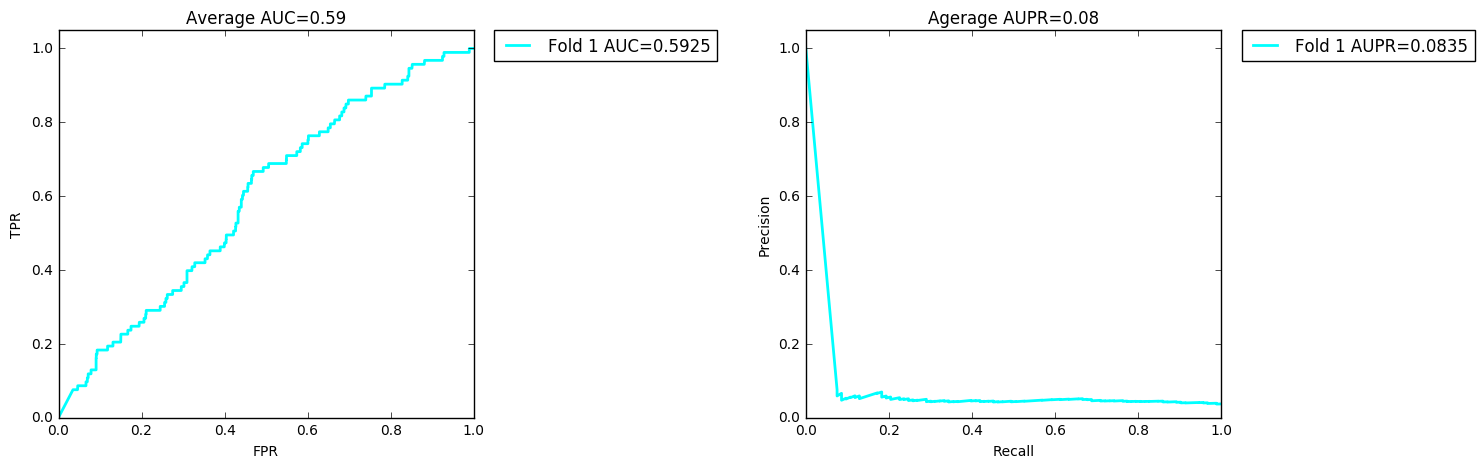

In [24]:
# removed descriptor, independent, 2017.3.15. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/1_9_LR_original_TN_whole_indep.txt", 'w') as f :
    user_c = 100
    f.write("<independent>\r\n")
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Wed 20:42:41
Wed 20:42:42


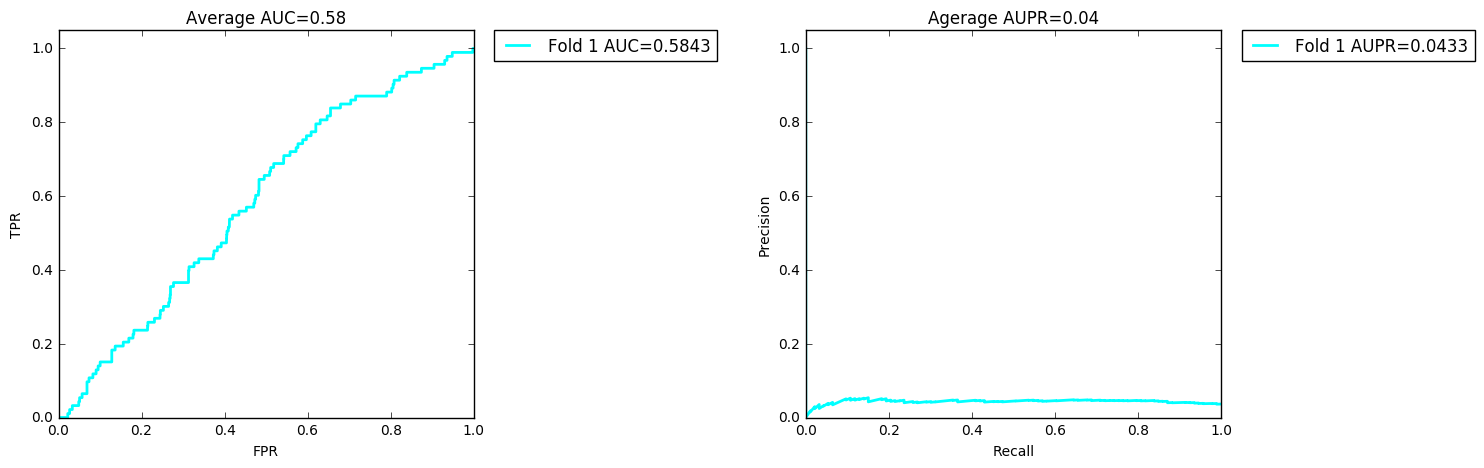

In [20]:
# original descriptor, independent, 2017.3.15. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/1_8_LR_original_TN_whole_indep.txt", 'w') as f :
    user_c = 100
    f.write("<independent>\r\n")
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Wed 20:28:32
Wed 20:28:33


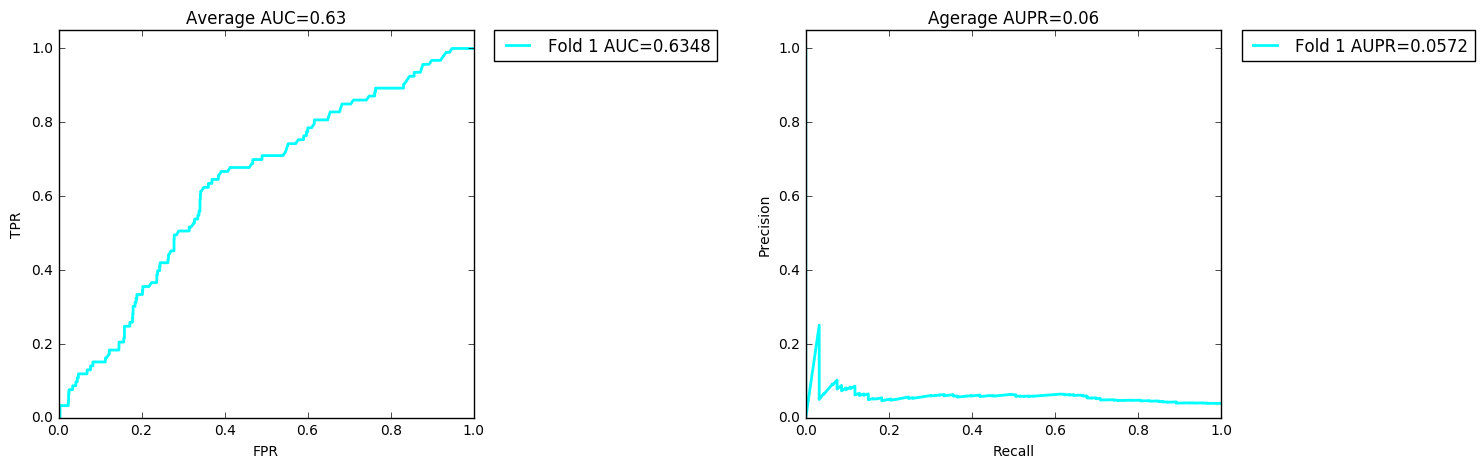

In [14]:
# removed descriptor, independent, 2017.3.10. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/1_7_LR_removed_indep_2.txt", 'w') as f :
    user_c = 0.1
    f.write("<independent>\r\n")
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Fri 01:39:50
Fri 01:40:29


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


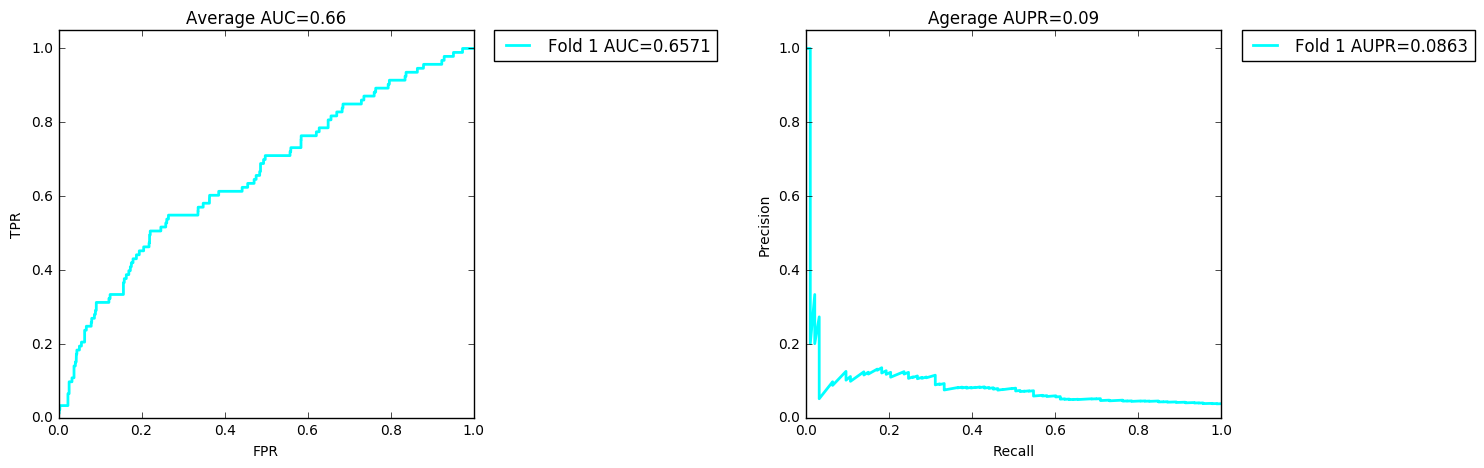

In [5]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.24 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/LR_original_ver2_indep.txt", 'w') as f :
    user_c = 1
    f.write("<independent>\r\n")
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

In [ ]:
x_whole_data_0_1

Fri 02:00:49
Fri 02:01:15


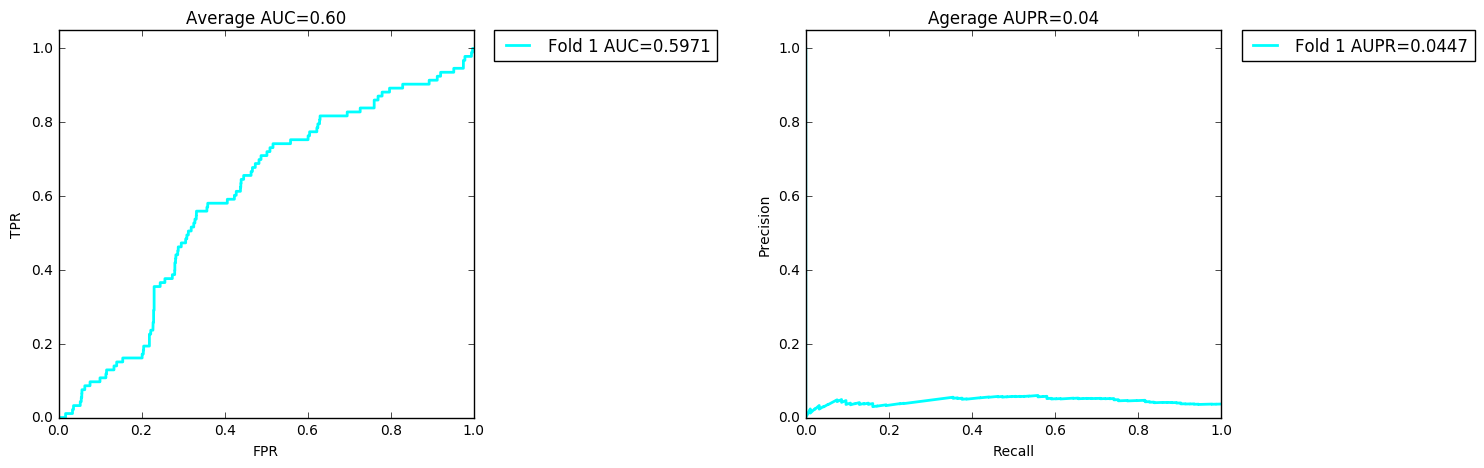

In [7]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.24 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/LR_0_1_ver2_indep.txt", 'w') as f :
    user_c = 1
    f.write("<independent>\r\n")
    
    classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier.fit(x_whole_data_0_1, y_whole_data_0_1)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

In [14]:
# 기존 dataset, independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_1_original_10-fold_indep.txt", 'w') as f :
    user_c = 0.001
    f.write("highest AUPR c={}----------------------------------------------------\r\n".format(user_c))
    f.write("<independent>\r\n")
    indep_results = Logist_Regression_independent(x_whole_data, y_whole_data, indep_x, indep_y, user_c)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
    
    user_c = 0.1
    f.write("highest AUC c={}----------------------------------------------------\r\n".format(user_c))
    indep_results = Logist_Regression_independent(x_whole_data, y_whole_data, indep_x, indep_y, user_c)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 11:23:03
Wed 11:27:04


In [10]:
# undersampling dataset(1%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_2_feature_based(1%)_indep.txt", 'w') as f :
    user_c = 1
    f.write("<independent>\r\n")
    indep_results = Logist_Regression_independent(x_whole_data_1, y_whole_data_1, indep_x, indep_y, user_c)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data_1, y_whole_data_1, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 10:13:05
Wed 10:14:38


In [11]:
# undersampling dataset(1%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_3_feature_based(0.5%)_indep.txt", 'w') as f :
    user_c = 1
    f.write("<independent>\r\n")
    indep_results = Logist_Regression_independent(x_whole_data_0_5, y_whole_data_0_5, indep_x, indep_y, user_c)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data_0_5, y_whole_data_0_5, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 10:14:38
Wed 10:16:59


In [12]:
# undersampling dataset(1%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_4_feature_based(0.1%)_indep.txt", 'w') as f :
    user_c = 1
    f.write("<independent>\r\n")
    indep_results = Logist_Regression_independent(x_whole_data_0_1, y_whole_data_0_1, indep_x, indep_y, user_c)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data_0_1, y_whole_data_0_1, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 10:16:59
Wed 10:21:30


In [8]:
# 기존 dataset, Random undersampling, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/1_5_Random_undersampling.txt", 'w') as f :
    user_c = 1
    print 'Random : ' + time.strftime('%a %H:%M:%S')
    f.write("<Random undersampling independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, rus)
    write_output(f, indep_results_10)
    
    print 'NearMiss : ' + time.strftime('%a %H:%M:%S')
    f.write("<NearMiss undersampling independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, nm)
    write_output(f, indep_results_10)
    
    print 'OneSidedSelection : ' + time.strftime('%a %H:%M:%S')
    f.write("<OneSidedSelection undersampling independent 1:1>\r\n")
    indep_results_10 = Logist_Regression_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_c, oss)
    write_output(f, indep_results_10)
    
print time.strftime('%a %H:%M:%S')


Tue 17:49:41
Random : Tue 17:49:41
NearMiss : Tue 17:57:30
OneSidedSelection : Tue 18:05:21
Tue 18:19:30
